# Setup

In [9]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import warnings
warnings.filterwarnings('ignore')


In [11]:
import os
os.getcwd()


'/Users/christellejoseph/code/Cyber_Tools/IDS'

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.tree import export_graphviz
import graphviz


In [13]:
csv_path = '/Users/christellejoseph/code/Cyber_Tools/IDS/data'
file_dir = os.listdir(csv_path)


In [14]:
csv_files = []
for file in file_dir:
    modified_file = file.replace('-WorkingHours', '').replace('-workingHours', '').replace(
                                        '-Afternoon', '').replace('-Morning', '').replace('.pcap_ISCX.csv', '')
    csv_files.append(modified_file)


# Merging: Dictionary Structure

In [15]:
data = {}

for name, filename in sorted(zip(csv_files, file_dir)):
    data[name] = pd.read_csv(os.path.join(csv_path, filename))


# Merging: Single DataFrame

In [16]:
all_data = pd.concat([pd.read_csv(os.path.join(csv_path, file)) for file in file_dir], ignore_index=True)

In [17]:
all_data.shape

(971180, 79)

In [18]:
all_data.columns = all_data.columns.str.strip()

In [19]:
all_data['Label'] = all_data['Label'].str.replace('�', '-', regex=False)

In [20]:
# all_data.to_csv('combined_df.csv', index=False)


In [21]:
all_data = all_data.drop_duplicates()

In [22]:
all_data.shape

(842322, 79)

In [23]:
all_data.isna().sum().sort_values(ascending=False)

Flow Bytes/s            53
Destination Port         0
Bwd Avg Bytes/Bulk       0
Fwd Avg Packets/Bulk     0
Fwd Avg Bytes/Bulk       0
                        ..
Bwd IAT Mean             0
Bwd IAT Total            0
Fwd IAT Min              0
Fwd IAT Max              0
Label                    0
Length: 79, dtype: int64

In [24]:
all_data = all_data.dropna(axis=1, how='any')

# Category Visualization

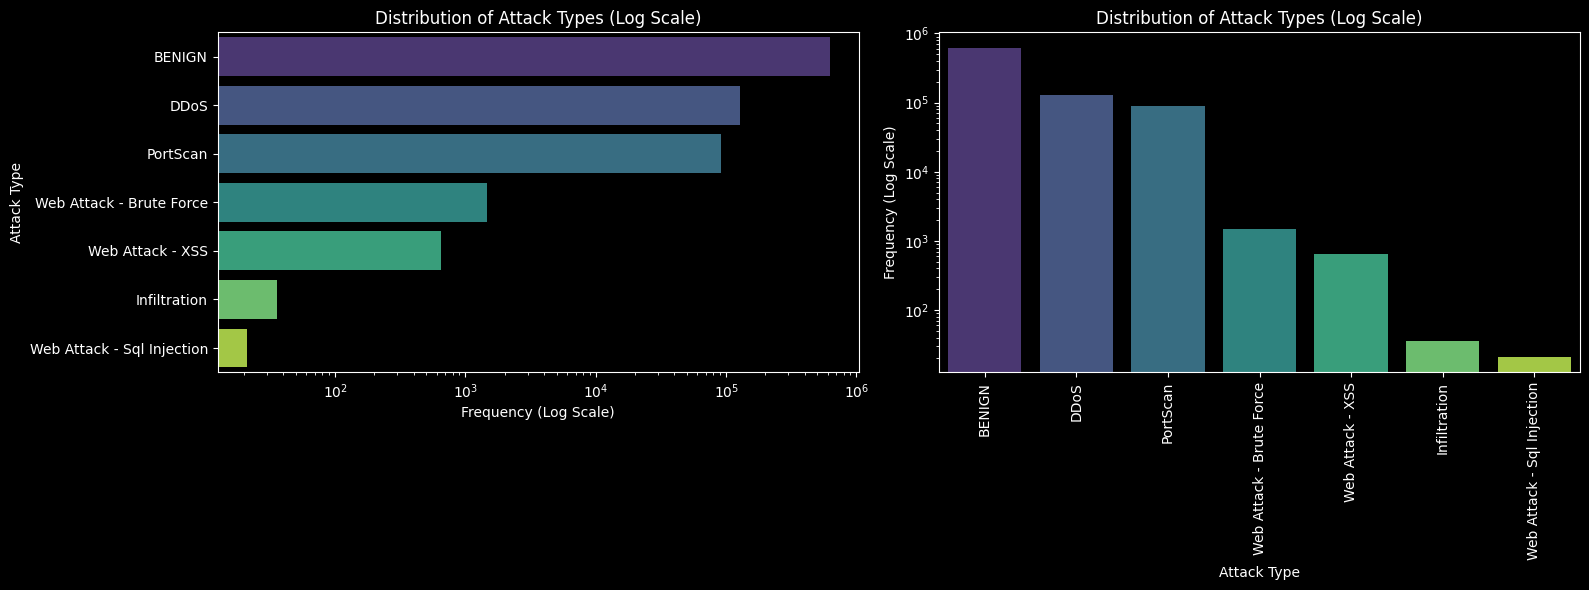

In [25]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

label_counts = all_data['Label'].value_counts().sort_values(ascending=False)
sns.countplot(y='Label', data=all_data, palette='viridis', order=label_counts.index, ax=axes[0])
axes[0].set_xscale('log')
axes[0].set_title('Distribution of Attack Types (Log Scale)')
axes[0].set_xlabel('Frequency (Log Scale)')
axes[0].set_ylabel('Attack Type')

sns.countplot(x='Label', data=all_data, palette='viridis', order=label_counts.index, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Distribution of Attack Types (Log Scale)')
axes[1].set_ylabel('Frequency (Log Scale)')
axes[1].set_xlabel('Attack Type')
axes[1].tick_params(axis='x', rotation=90) # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

In [26]:
all_data['Label'].value_counts()

BENIGN                        621308
DDoS                          128016
PortScan                       90819
Web Attack - Brute Force        1470
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: Label, dtype: int64

# Encoding

In [27]:
label_encoder = LabelEncoder()
all_data['Label'] = label_encoder.fit_transform(all_data['Label'])

#Get the mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'BENIGN': 0, 'DDoS': 1, 'Infiltration': 2, 'PortScan': 3, 'Web Attack - Brute Force': 4, 'Web Attack - Sql Injection': 5, 'Web Attack - XSS': 6}


In [28]:
all_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,0
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,0
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,0
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,0
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,0


In [29]:
all_data['Label'].value_counts()

0    621308
1    128016
3     90819
4      1470
6       652
2        36
5        21
Name: Label, dtype: int64

# Feature Selection & Engineering

Method 1: remove highly corrolated data.

In [30]:
correlation_matrix = all_data.corr()

In [31]:
high_corr = set()  # To keep track of the names of highly correlated features
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr.add(colname)


In [32]:
highCorr_reduced_df = all_data.drop(columns=high_corr)

In [33]:
data = highCorr_reduced_df

In [34]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Bwd Packet Length Max,Bwd Packet Length Min,Flow Packets/s,Flow IAT Mean,...,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Mean,Active Std,Idle Std,Label
0,22,166,1,0,0,0,0,0,12048.192770,166.0000,...,0,0,0,290,243,32,0.000,0.000,0.000,0
1,60148,83,1,0,0,0,0,0,36144.578310,41.5000,...,0,0,0,243,290,32,0.000,0.000,0.000,0
2,123,99947,1,48,48,48,48,48,20.010606,99947.0000,...,0,0,0,-1,-1,40,0.000,0.000,0.000,0
3,123,37017,1,48,48,48,48,48,54.029230,37017.0000,...,0,0,0,-1,-1,32,0.000,0.000,0.000,0
4,0,111161336,147,0,0,0,0,0,1.322402,761379.0137,...,0,0,0,-1,-1,0,1753752.625,2123197.578,2657727.996,0


Method 2: Random forest, and then look at the feature importance.

# Balancing The Dataset

In [77]:
#Solves - ValueError: Input X contains infinity or a value too large

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

X = data.select_dtypes(exclude='object').drop(columns = 'Label')
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [78]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
smote = SMOTE(sampling_strategy='auto', random_state=42)  
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Cross Validation & Grid search

In [37]:
# # Define a pipeline with preprocessing steps
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  
#     ('clf', LogisticRegression())  # This is a placeholder, actual classifier will be set by GridSearchCV
# ])

# # Define your models and their hyperparameters correctly
# model_params = {
#     'LogisticRegression': {
#         'clf': [LogisticRegression()],
#         'clf__C': [0.1, 1.0, 10.0],
#         'clf__class_weight': ['balanced', None]
#     },
#     'RandomForestClassifier': {
#         'clf': [RandomForestClassifier()],
#         'clf__n_estimators': [10, 50, 100],
#         'clf__max_depth': [None, 10, 20],
#         'clf__class_weight': ['balanced', None]
#     },
#     'SVC': {
#         'clf': [SVC()],
#         'clf__C': [0.1, 1.0, 10.0],
#         'clf__kernel': ['linear', 'rbf'],
#         'clf__class_weight': ['balanced', None]
#     }
# }

# # Correcting the GridSearch setup
# for model_name, params in model_params.items():
#     # Make a copy of the pipeline for each model to avoid mutating the same object
#     model_pipeline = Pipeline([
#         ('scaler', StandardScaler()),
#         ('clf', params['clf'][0])  # Set the classifier to the first instance in the list
#     ])
    
#     # Update params to remove the classifier instance, as it's now set directly in the pipeline
#     params = {k: v for k, v in params.items() if k != 'clf'}
    
#     # Create a new GridSearchCV object for each model
#     grid_search = GridSearchCV(model_pipeline, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     print(f"Best parameters for {model_name}: {grid_search.best_params_}")
#     print(f"Best cross-validated score for {model_name}: {grid_search.best_score_}")


Best parameters for LogisticRegression: {'clf__C': 10.0, 'clf__class_weight': None}

Best cross-validated score for LogisticRegression: 0.9663558854511145

Best parameters for RandomForestClassifier: {'clf__class_weight': None, 'clf__max_depth': None, 'clf__n_estimators': 100}

Best cross-validated score for RandomForestClassifier: 0.9986189886618331

# Machine Leaning Models 

## Decision Tree

In [80]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.995782161513511
Confusion Matrix:
 [[185721      7      0    302     87      0     78]
 [     9  38410      0      0      0      0      0]
 [     3      0      6      0      0      0      0]
 [   304      0      0  26946      1      0      2]
 [    34      0      0      0    255      2    136]
 [     1      0      0      0      0      4      2]
 [    11      0      0      1     85      0     92]]


In [39]:
# !pip install graphviz

In [40]:
class_names_str = [str(i) for i in np.unique(y)]
class_names_str

['0', '1', '2', '3', '4', '5', '6']

In [41]:
# dot_data = export_graphviz(clf, out_file=None, 
#                            feature_names= X_train.columns,
#                            class_names= class_names_str,  
#                            filled=True, rounded=True,  
#                            special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph.render("decision_tree")

In [82]:
def report_dt_model(model):
    model_preds = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, model_preds))
    print(classification_report(y_test, model_preds))
#     print('\n')
    plt.figure(figsize=(40, 12), dpi=200, 
#                facecolor='w'
              )  
    plot_tree(model, 
              feature_names=X.columns, 
              class_names=class_names_str, 
              filled=True, 
              fontsize=12)
        

In [88]:
prunned_tree = DecisionTreeClassifier(random_state=42, max_depth=3, criterion = 'entropy')

In [90]:
prunned_tree.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

Accuracy: 0.6136737175196734
              precision    recall  f1-score   support

           0       1.00      0.48      0.65    186195
           1       0.80      1.00      0.89     38419
           2       0.89      0.89      0.89         9
           3       0.28      0.99      0.44     27253
           4       0.01      0.08      0.02       427
           5       0.00      1.00      0.00         7
           6       0.06      0.95      0.11       189

    accuracy                           0.61    252499
   macro avg       0.43      0.77      0.43    252499
weighted avg       0.89      0.61      0.66    252499



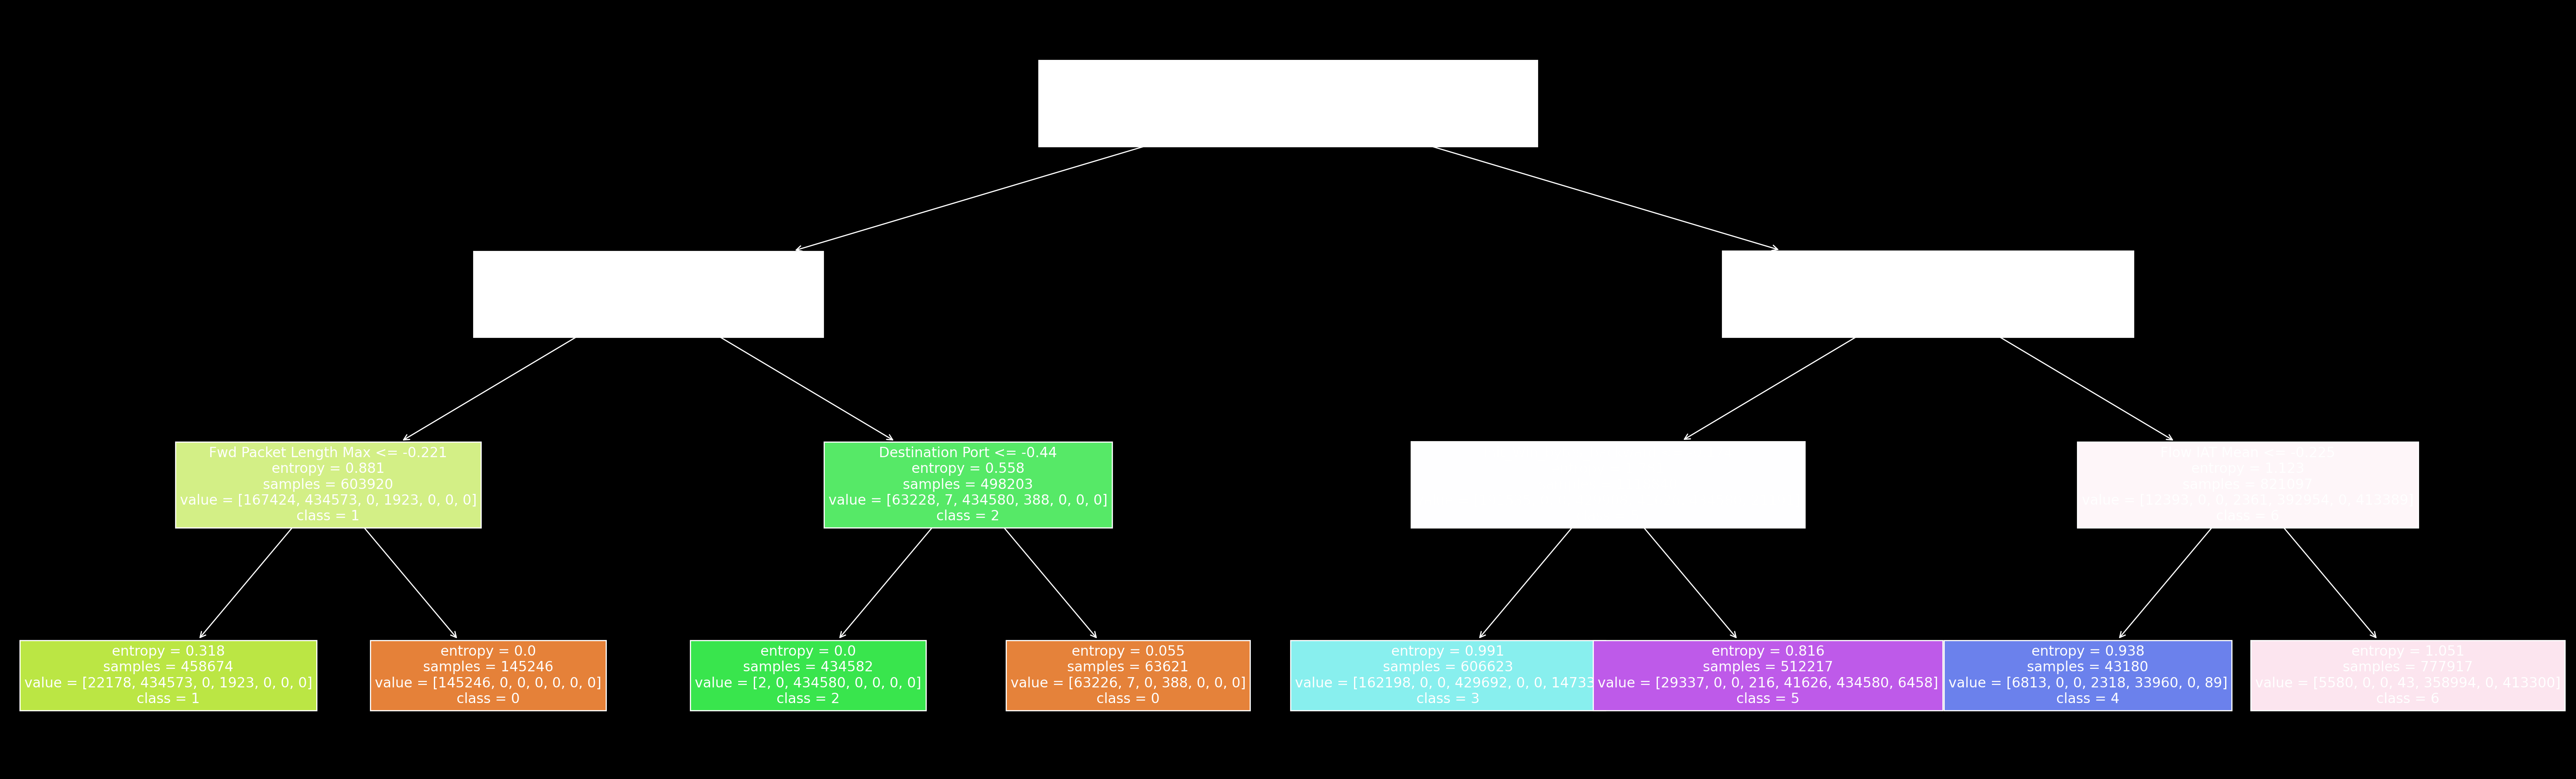

In [91]:
report_dt_model(prunned_tree)

## Random Forest 